### Figures for supplementary of 'Is the Fate of Deep Convective Systems written form the start?'

In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from tqdm import tqdm
import joblib
from scipy.stats import gaussian_kde
from scipy.stats import percentileofscore
import cartopy.crs as ccrs
import xarray as xr

import DeepFate
from DeepFate.model.utils_model import get_model
import os
from sklearn.preprocessing import StandardScaler



/home/b/b381993/miniconda3/envs/pytorch2/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:29: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


In [3]:
import DeepDyamond
from DeepDyamond import config
from DeepDyamond.datasets.load_toocan_dyamond import load_TOOCAN_DYAMOND
list_object_mcs = load_TOOCAN_DYAMOND(DeepDyamond.config.PATH_TOOCAN_GLOBAL_FILE)

from DeepDyamond.datasets.load_toocan_dyamond import load_TOOCAN_DYAMOND
list_object_mcs = load_TOOCAN_DYAMOND(DeepDyamond.config.PATH_TOOCAN_GLOBAL_FILE)

from DeepDyamond.datasets.generate_precomputed_datasets import get_specs_mcs, get_z_data
from DeepDyamond.datasets.utils import get_list_valid_mcs
from DeepDyamond.datasets.utils import get_validity_lifecycles_start_end
list_valid_mcs = get_list_valid_mcs(list_object_mcs = list_object_mcs,
                   max_area=40000,
                    min_area=DeepDyamond.config.MCS_SPECS_RANGE['max_area'][0],
                    duration_max = 100,
                    duration_min = 3,
                    lat_max=DeepDyamond.config.MAX_LAT_TROPICS)

validitity, start_times, end_times = get_validity_lifecycles_start_end(list_valid_mcs)
list_valid_mcs_2 = [list_valid_mcs[i] for i in range(len(list_valid_mcs)) if validitity[i] is True]
list_start_times = [start_times[i] for i in range(len(list_valid_mcs)) if validitity[i] is True]
list_end_times = [end_times[i] for i in range(len(list_valid_mcs)) if validitity[i] is True]


/work/bb1153/b381993/data3/data/TOOCAN-GLOBAL-20160901-20160910.dat.gz
/work/bb1153/b381993/data3/data/TOOCAN-GLOBAL-20160901-20160910.dat.gz


100%|██████████| 58719/58719 [00:02<00:00, 23873.30it/s]


In [4]:
def get_images_from_mcs_idx(mcs_idx, list_var, with_labels=False):
    mcs, utime_list, lat_list, lon_list, label_mcs = list_valid_mcs_2[mcs_idx], utc_list_all[mcs_idx], lat_list_all[mcs_idx], lon_list_all[mcs_idx], label_all[mcs_idx]
    
    X_all = np.zeros((len(list_var), len(utime_list), 128,128))
    
    for idx_time in range(len(utime_list)):
        path_dyamond_dir_utc_time = generate_dyamond_file_path_from_utc(utime_list[idx_time], df_relation_table_UTC=df_relation_table)
        path_toocan_file_utc_time = generate_img_seg_file_path_from_utc(utime_list[idx_time], df_relation_table_UTC=df_relation_table)
        lat, long =  lat_list[idx_time], lon_list[idx_time] 
        for i_var, var in enumerate(list_var):
            if var =='MCS_segmentation_mask_only' : 
                    file_path = os.path.join(DeepDyamond.config.PATH_SEGMENTED_IMGS, path_toocan_file_utc_time)
                    X = open_xarray_rolling_lon(file_path = file_path, 
                                                lat_bary = lat, 
                                                lon_bary = long, 
                                                lat_delta = lat_delta_degrees, 
                                                lon_delta = lon_delta_degrees, 
                                                output_shape = (lat_delta_pixels, lon_delta_pixels),
                                                keys_sel=('latitude', 'longitude'))
                    
                    X = binary_segmentation_mask_processing(data = X, label = label_mcs, transparency=True)
                    X=np.mod(X,15)
            elif var =='MCS_segmentation' :
                    file_path = os.path.join(DeepDyamond.config.PATH_SEGMENTED_IMGS, path_toocan_file_utc_time)
                    X = open_xarray_rolling_lon(file_path = file_path, 
                                                lat_bary = lat, 
                                                lon_bary = long, 
                                                lat_delta = lat_delta_degrees, 
                                                lon_delta = lon_delta_degrees, 
                                                output_shape = (lat_delta_pixels, lon_delta_pixels),
                                                keys_sel=('latitude', 'longitude'))
                    X[X==0]=np.nan
                    #X[X==1]=label_mcs
                    if not with_labels:
                        X=np.mod(X,15)
                    else:
                        None
                    
            else:
                    file_path = os.path.join(DeepDyamond.config.PATH_DYAMOND_ROOT_DIR,path_dyamond_dir_utc_time +'.'+var+'.nc')
                    X = open_xarray_rolling_lon(file_path = file_path, 
                            lat_bary = lat, 
                            lon_bary = long, 
                            lat_delta = lat_delta_degrees, 
                            lon_delta = lon_delta_degrees, 
                            output_shape = (lat_delta_pixels, lon_delta_pixels),
                            keys_sel=('lat', 'lon'))
                    
                    
            X_all[i_var, idx_time, :,:]= X
            
    return X_all
                    

In [5]:
import pandas as pd
df_relation_table = pd.read_csv(DeepDyamond.config.PATH_RELATION_TABLE)
lat_delta_pixels = DeepDyamond.config.SPACE_WINDOW['lat_delta_pixels']
lon_delta_pixels = DeepDyamond.config.SPACE_WINDOW['lon_delta_pixels']
lat_delta_degrees = DeepDyamond.config.SPACE_WINDOW['lat_delta_degrees']
lon_delta_degrees = DeepDyamond.config.SPACE_WINDOW['lon_delta_degrees']
lat_list_all=[]
lon_list_all=[]
utc_list_all=[]
duration_all=[]
label_all=[]
for mcs, start_idx, end_idx in zip(list_valid_mcs_2,list_start_times, list_end_times) :
    lat_list_all.append(mcs.clusters.lat[start_idx:end_idx])
    lon_list_all.append(mcs.clusters.lon[start_idx:end_idx])
    utc_list_all.append(mcs.clusters.Utime[start_idx:end_idx])
    duration_all.append(0.5*(end_idx-start_idx))
    label_all.append(mcs.label)

In [6]:
from DeepDyamond.datasets.utils import generate_img_seg_file_path_from_utc, generate_dyamond_file_path_from_utc, open_xarray_rolling_lon, binary_segmentation_mask_processing, compute_delta_time, transparency_processing

from DeepDyamond.datasets.generate_precomputed_datasets import get_specs_mcs


In [7]:
list_var = ['MCS_segmentation_mask_only',                                          
           'LWNTA.2D',
           'PW.2D', 
           'IWP.2D', 
            'MCS_segmentation',
           'RH500.2D',
           'T2mm.2D', 
           'OM700.2D','U10m.2D']

            
                                                            
mcs_idx=150
X_all = get_images_from_mcs_idx(mcs_idx=mcs_idx, list_var=list_var, with_labels=True)

In [8]:
i_time = 2
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

fig, ax = plt.subplots(2,4, figsize=(10,6), constrained_layout=True)

cmap_list=['rainbow',  'Greys', 'PuBuGn', 'viridis', 'rainbow', 'Spectral', 'coolwarm', 'GnBu', 'cividis_r']

title_list=['DCS',  'LWNTA [W/m$^2$]', 'PW [kg/m$^2$]', 'IWP [kg/m$^2$]', 'Neighbors','RH 500hPa [1]', 'T surf [K]','OM 700hPa [Pa/s]', 'U surf [m/s]',  ]

for i in range(8):
    
    j=i%4
    
    if i<4:
        k=0
    elif 3<i<8:
        k=1
        
    print(k,j)
    scalebar = AnchoredSizeBar(ax[k,j].transData,
                           30, '100km', 'lower center', 
                           pad=1,
                           color='k',
                           frameon=False,
                           size_vertical=1,
                           )
    
    if title_list[i]=='Neighbors':
        map_X = X_all[i, i_time,:,:]%10
        im = ax[k,j].contourf(map_X, 30, cmap=cmap_list[i], alpha=0.8)
        im2 = ax[k,j].contourf(X_all[0, i_time,:,:], 30, cmap=cmap_list[i])
        
    else:
        im = ax[k,j].contourf(X_all[i, i_time,:,:], 30, cmap=cmap_list[i])
        
       
    vmin_im, vmax_im = np.min(X_all[i, i_time,:,:]), np.max(X_all[i, i_time,:,:])
    t = np.linspace(vmin_im, vmax_im, 3)
    ax[k,j].add_artist(scalebar)
    ax[k,j].set_xticks([])
    ax[k,j].set_yticks([])
    ax[k,j].set_title(title_list[i], fontstyle='italic')
    
    
    
    if (title_list[i]!='DCS') and (title_list[i]!='Neighbors'):
        
        #divider = make_axes_locatable(ax[k,j])
        #cax = divider.append_axes('bottom', size='5%')#, pad=0.05)
        
        cb = fig.colorbar(im, ax=ax[k,j], orientation='horizontal',  ticks=t, aspect=20, shrink=0.7, format='%.1f')
    ax[k,j].set_aspect('equal')

# Assuming you have your axes already created as ax1, ax2, and ax3
labels = ['A.', 'B.', 'C.', 'D.', 'E.', 'F.', 'G.', 'H.']
pnas_bg_color = '#d9e6f2'  # PNAS light blue color for background
pnas_text_color = '#0033a0'  # PNAS dark blue color for text

for i,ax in enumerate([ax[0,0], ax[0,1], ax[0,2],ax[0,3],
           ax[1,0], ax[1,1], ax[1,2], ax[1,3]]):
    ax.text(
        0.04, 0.89, labels[i], 
        transform=ax.transAxes, 
        weight='bold',
        color=pnas_text_color,  # Text color
        bbox=dict(facecolor=pnas_bg_color, edgecolor='none', boxstyle='round,pad=0.3')  # Background color with padding
    )

    

path_figures = '/home/b/b381993/DeepFate/figures_si'   
path_fig = os.path.join(path_figures, 'example_window_sys_variables.pdf')
plt.savefig(path_fig)



0 0
0 1
0 2
0 3
1 0
1 1
1 2
1 3


In [9]:
path_figures = '/home/b/b381993/DeepFate/figures_si'

In [10]:
import matplotlib
plt.rcParams.update({'font.size': 14})

In [11]:
df_train = pd.read_csv('/work/bb1153/b381993/data/FINAL_VERSION_new/train_dataset.csv')
df_test = pd.read_csv('/work/bb1153/b381993/data/FINAL_VERSION_new/test_dataset.csv')

In [12]:
from DeepFate.model.utils_model import predict_model

In [13]:
folder_path = '/work/bb1153/b381993/data/FINAL_VERSION_new/'

folder_path_preds = os.path.join(folder_path, 'saved_preds')
path_to_preds_df = os.path.join(folder_path_preds, 'preds_all_models_all_features.parquet')
df_all_features=pd.read_parquet(path_to_preds_df)

cmap=plt.get_cmap('rainbow',5)

model_str = 'Lasso'

fig, ax=plt.subplots()
ax2=plt.twinx(ax)

for nb_timesteps in [1,2,3,4]:

        str_dict = f'{model_str}_{nb_timesteps}'

        y_preds =df_all_features[df_all_features['model']==str_dict]['preds'].values
        y_test =df_all_features[df_all_features['model']==str_dict]['truth'].values

        y_preds=y_preds[0]
        y_test = y_test[0]

        if nb_timesteps==1:
            im2=ax.scatter(y_test, 100*(np.sqrt((np.mean(y_test)-y_test)**2)/y_test), 
                            marker='+', c='k', s=1, label='Constant Prediction')
            ax2.hist(y_test, bins=40, alpha=0.2, color='tab:blue')

    
        yy = 100*(np.sqrt((y_preds-y_test)**2)/y_test)
        xx = y_test
        nbins = 20
        n, _ = np.histogram(xx, bins=nbins)
        sy, _ = np.histogram(xx, bins=nbins, weights=yy)
        sy2, _ = np.histogram(xx, bins=nbins, weights=yy*yy)
        mean = sy / n
        std = np.sqrt(sy2/n - mean*mean)

        ax.errorbar((_[1:] + _[:-1])/2, mean, yerr=std,fmt='--', capsize=4, capthick=2, color=cmap(nb_timesteps), label=f'Period : {nb_timesteps*0.5}h')
        
        ax.set_xlim(40,300)
        #ax.ylim(-5,80)
        ax.set_title('Lasso, all features', fontstyle='italic')
        ax.set_xlabel('Maximal Extension [km]')
        ax.set_ylabel('RSME relative to the size [%]')
        ax.legend(ncol=3, bbox_to_anchor=(0.5,1.35), loc= 'upper center')
        
        ax.grid(True)


# Assuming you have your axes already created as ax1, ax2, and ax3
labels = ['B.']
pnas_bg_color = '#d9e6f2'  # PNAS light blue color for background
pnas_text_color = '#0033a0'  # PNAS dark blue color for text

ax.text(
    0.02, 0.93, labels[0], 
    transform=ax.transAxes, 
    weight='bold',
    color=pnas_text_color,  # Text color
    bbox=dict(facecolor=pnas_bg_color, edgecolor='none', boxstyle='round,pad=0.3')  # Background color with padding
)


path_to_save = os.path.join(path_figures, 'figure_S5A.pdf')
plt.savefig(path_to_save)



In [14]:
folder_path = '/work/bb1153/b381993/data/FINAL_VERSION_new/'

folder_path_preds = os.path.join(folder_path, 'saved_preds')
path_to_preds_df = os.path.join(folder_path_preds, 'preds_all_models_only_growth_rate.parquet')
df_only=pd.read_parquet(path_to_preds_df)

cmap=plt.get_cmap('rainbow',5)

model_str = 'Lasso'

fig, ax=plt.subplots()
ax2=plt.twinx(ax)

for nb_timesteps in [1,2,3,4]:

        str_dict = f'{model_str}_{nb_timesteps}'

        y_preds =df_only[df_only['model']==str_dict]['preds'].values
        y_test =df_only[df_only['model']==str_dict]['truth'].values

        y_preds=y_preds[0]
        y_test = y_test[0]

        if nb_timesteps==1:
            im2=ax.scatter(y_test, 100*(np.sqrt((np.mean(y_test)-y_test)**2)/y_test), 
                            marker='+', c='k', s=1, label='Constant Prediction')
            ax2.hist(y_test, bins=40, alpha=0.2, color='tab:blue')

    
        yy = 100*(np.sqrt((y_preds-y_test)**2)/y_test)
        xx = y_test
        nbins = 20
        n, _ = np.histogram(xx, bins=nbins)
        sy, _ = np.histogram(xx, bins=nbins, weights=yy)
        sy2, _ = np.histogram(xx, bins=nbins, weights=yy*yy)
        mean = sy / n
        std = np.sqrt(sy2/n - mean*mean)

        ax.errorbar((_[1:] + _[:-1])/2, mean, yerr=std,fmt='--', capsize=4, capthick=2, color=cmap(nb_timesteps), label=f'Period : {nb_timesteps*0.5}h')

        
        ax.set_xlim(40,300)
        #ax.ylim(-5,80)
        ax.set_title('Lasso, only growth rate area', fontstyle='italic')
        ax.set_xlabel('Maximal Extension [km]')
        ax.set_ylabel('RSME relative to the size [%]')
        ax.legend(ncol=3, bbox_to_anchor=(0.5,1.35), loc= 'upper center')
        
        ax.grid(True)

# Assuming you have your axes already created as ax1, ax2, and ax3
labels = ['A.']
pnas_bg_color = '#d9e6f2'  # PNAS light blue color for background
pnas_text_color = '#0033a0'  # PNAS dark blue color for text

ax.text(
    0.02, 0.93, labels[0], 
    transform=ax.transAxes, 
    weight='bold',
    color=pnas_text_color,  # Text color
    bbox=dict(facecolor=pnas_bg_color, edgecolor='none', boxstyle='round,pad=0.3')  # Background color with padding
)


path_to_save = os.path.join(path_figures, 'figure_S5B.pdf')
plt.savefig(path_to_save)

In [15]:
folder_path = '/work/bb1153/b381993/data/FINAL_VERSION_new/'

folder_path_preds = os.path.join(folder_path, 'saved_preds')
path_to_preds_df = os.path.join(folder_path_preds, 'preds_all_models_all_features.parquet')
df_all_features=pd.read_parquet(path_to_preds_df)

cmap=plt.get_cmap('rainbow',5)

model_str = 'RandomForest'

fig, ax=plt.subplots()
ax2=plt.twinx(ax)

for nb_timesteps in [1,2,3,4]:

        str_dict = f'{model_str}_{nb_timesteps}'

        y_preds =df_all_features[df_all_features['model']==str_dict]['preds'].values
        y_test =df_all_features[df_all_features['model']==str_dict]['truth'].values

        y_preds=y_preds[0]
        y_test = y_test[0]

        if nb_timesteps==1:
            im2=ax.scatter(y_test, 100*(np.sqrt((np.mean(y_test)-y_test)**2)/y_test), 
                            marker='+', c='k', s=1, label='Constant Prediction')
            ax2.hist(y_test, bins=40, alpha=0.2, color='tab:blue')

    
        yy = 100*(np.sqrt((y_preds-y_test)**2)/y_test)
        xx = y_test
        nbins = 20
        n, _ = np.histogram(xx, bins=nbins)
        sy, _ = np.histogram(xx, bins=nbins, weights=yy)
        sy2, _ = np.histogram(xx, bins=nbins, weights=yy*yy)
        mean = sy / n
        std = np.sqrt(sy2/n - mean*mean)

        ax.errorbar((_[1:] + _[:-1])/2, mean, yerr=std,fmt='--', capsize=4, capthick=2, color=cmap(nb_timesteps), label=f'Period : {nb_timesteps*0.5}h')

        
        ax.set_xlim(40,300)
        #ax.ylim(-5,80)
        ax.set_title('Random Forest, all features', fontstyle='italic')
        ax.set_xlabel('Maximal Extension [km]')
        ax.set_ylabel('RSME relative to the size [%]')
        ax.legend(ncol=3, bbox_to_anchor=(0.5,1.35), loc= 'upper center')
        
        ax.grid(True)

# Assuming you have your axes already created as ax1, ax2, and ax3
labels = ['D.']
pnas_bg_color = '#d9e6f2'  # PNAS light blue color for background
pnas_text_color = '#0033a0'  # PNAS dark blue color for text

ax.text(
    0.02, 0.93, labels[0], 
    transform=ax.transAxes, 
    weight='bold',
    color=pnas_text_color,  # Text color
    bbox=dict(facecolor=pnas_bg_color, edgecolor='none', boxstyle='round,pad=0.3')  # Background color with padding
)


path_to_save = os.path.join(path_figures, 'figure_S5C.pdf')
plt.savefig(path_to_save)

In [16]:
folder_path = '/work/bb1153/b381993/data/FINAL_VERSION_new/'

folder_path_preds = os.path.join(folder_path, 'saved_preds')
path_to_preds_df = os.path.join(folder_path_preds, 'preds_all_models_only_growth_rate.parquet')
df_only=pd.read_parquet(path_to_preds_df)

cmap=plt.get_cmap('rainbow',5)

model_str = 'RandomForest'

fig, ax=plt.subplots()
ax2=plt.twinx(ax)

for nb_timesteps in [1,2,3,4]:

        str_dict = f'{model_str}_{nb_timesteps}'

        y_preds =df_only[df_only['model']==str_dict]['preds'].values
        y_test =df_only[df_only['model']==str_dict]['truth'].values

        y_preds=y_preds[0]
        y_test = y_test[0]

        if nb_timesteps==1:
            im2=ax.scatter(y_test, 100*(np.sqrt((np.mean(y_test)-y_test)**2)/y_test), 
                            marker='+', c='k', s=1, label='Constant Prediction')
            ax2.hist(y_test, bins=40, alpha=0.2, color='tab:blue')

    
        yy = 100*(np.sqrt((y_preds-y_test)**2)/y_test)
        xx = y_test
        nbins = 20
        n, _ = np.histogram(xx, bins=nbins)
        sy, _ = np.histogram(xx, bins=nbins, weights=yy)
        sy2, _ = np.histogram(xx, bins=nbins, weights=yy*yy)
        mean = sy / n
        std = np.sqrt(sy2/n - mean*mean)

        ax.errorbar((_[1:] + _[:-1])/2, mean, yerr=std,fmt='--', capsize=4, capthick=2, color=cmap(nb_timesteps), label=f'Period : {nb_timesteps*0.5}h')

        
        ax.set_xlim(40,300)
        #ax.ylim(-5,80)
        ax.set_title('Random Forest, only growth rate area', fontstyle='italic')
        ax.set_xlabel('Maximal Extension [km]')
        ax.set_ylabel('RSME relative to the size [%]')
        ax.legend(ncol=3, bbox_to_anchor=(0.5,1.35), loc= 'upper center')
        
        ax.grid(True)

# Assuming you have your axes already created as ax1, ax2, and ax3
labels = ['C.']
pnas_bg_color = '#d9e6f2'  # PNAS light blue color for background
pnas_text_color = '#0033a0'  # PNAS dark blue color for text

ax.text(
    0.02, 0.93, labels[0], 
    transform=ax.transAxes, 
    weight='bold',
    color=pnas_text_color,  # Text color
    bbox=dict(facecolor=pnas_bg_color, edgecolor='none', boxstyle='round,pad=0.3')  # Background color with padding
)

path_to_save = os.path.join(path_figures, 'figure_S5D.pdf')
plt.savefig(path_to_save)


In [17]:
df_test = pd.read_csv('/work/bb1153/b381993/data/FINAL_VERSION_new/test_dataset.csv')


In [18]:
folder_path = '/work/bb1153/b381993/data/FINAL_VERSION_new/'

folder_path_preds = os.path.join(folder_path, 'saved_preds')
path_to_preds_df = os.path.join(folder_path_preds, 'preds_all_models_all_features.parquet')
df_all_features=pd.read_parquet(path_to_preds_df)

cmap=plt.get_cmap('rainbow',5)
fig, ax = plt.subplots(1, 2, figsize=(13,5), constrained_layout=True)


model_str = 'Lasso'

for i,nb_timesteps in enumerate([2,3]):

    str_dict = f'{model_str}_{nb_timesteps}'
    
    y_preds =df_all_features[df_all_features['model']==str_dict]['preds'].values
    y_test =df_all_features[df_all_features['model']==str_dict]['truth'].values
    
    y_preds=y_preds[0]
    y_test = y_test[0]
    
    x=100*(np.sqrt((y_preds-y_test)**2)/y_test)
    y = df_test['y_duration']
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    
    yy = 100*(np.sqrt((y_preds-y_test)**2)/y_test)
    xx = df_test['y_duration']
    nbins = np.arange(4,19,1)
    n, _ = np.histogram(xx, bins=nbins)
    sy, _ = np.histogram(xx, bins=nbins, weights=yy)
    sy2, _ = np.histogram(xx, bins=nbins, weights=yy*yy)
    mean = sy / n
    std = np.sqrt(sy2/n - mean*mean)
    
    im=ax[i].scatter(df_test['y_duration'], 100*(np.sqrt((y_preds-y_test)**2)/y_test), marker='+', c=1000*z, alpha=0.6, vmin=0, vmax=10)
    ax[i].errorbar((_[1:] + _[:-1])/2, mean, yerr=std,fmt='--', capsize=4, capthick=2, color='k')
    
    #plt.clim(0,0.7)
    ax[i].set_xlim(4,20)
    ax[i].set_ylim(0,85)
    ax[i].set_title(f'Multi-linear model, all features, {nb_timesteps/2}h', fontstyle='italic')
    ax[i].set_xlabel('Duration [h]')
    ax[i].set_ylabel('RSME relative to the size [%]')
    ax[i].grid(True)

cb=fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.6, orientation='horizontal', aspect=110, label=r'Density [$10^{-3}$]')

# Assuming you have your axes already created as ax1, ax2, and ax3
labels = ['A.', 'B.']
pnas_bg_color = '#d9e6f2'  # PNAS light blue color for background
pnas_text_color = '#0033a0'  # PNAS dark blue color for text

for i, ax_subi in enumerate([ax[0],ax[1]]):
    ax_subi.text(
        0.02, 0.92, labels[i], 
        transform=ax_subi.transAxes, 
        weight='bold',
        color=pnas_text_color,  # Text color
        bbox=dict(facecolor=pnas_bg_color, edgecolor='none', boxstyle='round,pad=0.3')  # Background color with padding
    )



path_to_save = os.path.join(path_figures, 'figure_S6.pdf')
plt.savefig(path_to_save)

In [19]:
folder_path = '/work/bb1153/b381993/data/FINAL_VERSION_new/'

folder_path_preds = os.path.join(folder_path, 'saved_preds')
path_to_preds_df = os.path.join(folder_path_preds, 'preds_all_models_all_features.parquet')
df_all_features=pd.read_parquet(path_to_preds_df)


for i_model,model_str in enumerate(['RandomForest', 'MLPRegressor']):

    fig = plt.figure(layout="constrained",  figsize=(8,18))

    gs = GridSpec(100, 6, figure=fig)

    ax1 = fig.add_subplot(gs[:30, :])
    ax2 = fig.add_subplot(gs[30:60, :])
    ax4 = fig.add_subplot(gs[60:70, :])


    #### ax1
    nb_timesteps=3
    str_dict = f'{model_str}_{nb_timesteps}'

    y_preds =df_all_features[df_all_features['model']==str_dict]['preds'].values
    y_test =df_all_features[df_all_features['model']==str_dict]['truth'].values


    x=y_preds[0]
    y = y_test[0]

    xy = np.vstack([x,y])
    xy=np.array(xy)
    z = gaussian_kde(xy)(xy)


    im = ax1.scatter( y_test[0],  y_preds[0], marker = '+', c =1000*z, alpha=0.7, cmap='YlGnBu_r')

    ax1.set_xlim(40,220)
    ax1.set_ylim(40,220)
    #plt.title('Multi-Linear Model, all features, 1h', fontstyle='italic')
    ax1.set_xlabel('Maximal Extension (Ground Truth) [km]')
    ax1.set_ylabel('Prediction [km]')



    ax1.plot(y_test[0], y_test[0], color='k', linestyle='dashed')
    #plt.plot(y_test, 1.13*y_test-13.78967328)
    ax1.grid(True)
    #plt.plot(y_test, y_test)

    ax1.text(50, 180, f'All features, {nb_timesteps/2}h', style='italic', bbox={'facecolor': 'tab:blue', 'alpha': 0.5, 'pad': 10})



    ### ax2
    nb_timesteps=4
    str_dict = f'{model_str}_{nb_timesteps}'
    y_preds =df_all_features[df_all_features['model']==str_dict]['preds'].values
    y_test =df_all_features[df_all_features['model']==str_dict]['truth'].values

    x=y_preds[0]
    y = y_test[0]
    xy = np.vstack([x,y])
    xy = np.array(xy)
    
    print(xy.shape)
    
    z = gaussian_kde(xy)(xy)


    #im = plt.scatter( y_test**2,  0.5*(y_preds_lr**2+y_preds_rf**2), marker = '+', c = df_test['y_duration'], alpha=0.6)
    #im = plt.scatter( y_test, 0.5*(y_preds_lr+y_preds_rf), marker = '+', c =z)
    im = ax2.scatter( y_test[0],  y_preds[0], marker = '+', c =1000*z, alpha=0.7, cmap='YlGnBu_r')

    ax2.set_xlim(40,220)
    ax2.set_ylim(40,220)
    #plt.title('Multi-Linear Model, all features, 1.5h', fontstyle='italic')
    ax2.set_xlabel('Maximal Extension (Ground Truth) [km]')
    ax2.set_ylabel('Prediction [km]')

    #ax[1].clim(0,0.5)


    ax2.plot(y_test[0], y_test[0], color='k', linestyle='dashed')
    #plt.plot(y_test, 1.13*y_test-13.78967328)
    ax2.grid(True)
    #plt.plot(y_test, y_test)

    ax2.text(50, 180, f'All features, {nb_timesteps/2}h', style='italic', bbox={'facecolor': 'tab:blue', 'alpha': 0.5, 'pad': 10})

    fig.colorbar(im, orientation='horizontal', label=r'Density [$10^{-3}$]', aspect=110, pad=-0.7, ax=ax4)

    ax4.set_axis_off()

(2, 17229)
(2, 17229)


In [20]:
#folder_path = '/work/bb1153/b381993/data/FINAL_VERSION_new/'
folder_path = '/work/bb1153/b381993/data/FINAL_VERSION_PNAS/'

folder_path_preds = os.path.join(folder_path, 'saved_preds')
path_to_preds_df = os.path.join(folder_path_preds, 'preds_all_models_only_growth_rate.parquet')
df_only=pd.read_parquet(path_to_preds_df)

for i_model,model_str in enumerate(['Lasso', 'MLPRegressor']):

    fig = plt.figure(layout="constrained",  figsize=(8,18))

    gs = GridSpec(100, 6, figure=fig)

    ax1 = fig.add_subplot(gs[:30, :])
    ax2 = fig.add_subplot(gs[30:60, :])


    #### ax1
    nb_timesteps=2
    str_dict = f'{model_str}_{nb_timesteps}'

    y_preds =df_only[df_only['model']==str_dict]['preds'].values
    y_test =df_only[df_only['model']==str_dict]['truth'].values


    x=y_preds[0]
    y = y_test[0]

    xy = np.vstack([x,y])
    xy=np.array(xy)
    z = gaussian_kde(xy)(xy)


    im = ax1.scatter( y_test[0],  y_preds[0], marker = '+', c =1000*z, alpha=0.7, cmap='YlGnBu_r')

    ax1.set_xlim(40,220)
    ax1.set_ylim(40,220)
    #plt.title('Multi-Linear Model, all features, 1h', fontstyle='italic')
    ax1.set_xlabel('Maximal Extension (Ground Truth) [km]')
    ax1.set_ylabel('Prediction [km]')



    ax1.plot(y_test[0], y_test[0], color='k', linestyle='dashed')
    #plt.plot(y_test, 1.13*y_test-13.78967328)
    ax1.grid(True)
    #plt.plot(y_test, y_test)

    ax1.text(50, 180, f'Only growth rate, {nb_timesteps/2}h', style='italic', bbox={'facecolor': 'tab:blue', 'alpha': 0.5, 'pad': 10})



    ### ax2
    nb_timesteps=4
    str_dict = f'{model_str}_{nb_timesteps}'
    y_preds =df_only[df_only['model']==str_dict]['preds'].values
    y_test =df_only[df_only['model']==str_dict]['truth'].values

    x=y_preds[0]
    y = y_test[0]
    xy = np.vstack([x,y])
    xy = np.array(xy)
    
    print(xy.shape)
    
    z = gaussian_kde(xy)(xy)


    #im = plt.scatter( y_test**2,  0.5*(y_preds_lr**2+y_preds_rf**2), marker = '+', c = df_test['y_duration'], alpha=0.6)
    #im = plt.scatter( y_test, 0.5*(y_preds_lr+y_preds_rf), marker = '+', c =z)
    im = ax2.scatter( y_test[0],  y_preds[0], marker = '+', c =1000*z, alpha=0.7, cmap='YlGnBu_r')

    ax2.set_xlim(40,220)
    ax2.set_ylim(40,220)
    #plt.title('Multi-Linear Model, all features, 1.5h', fontstyle='italic')
    ax2.set_xlabel('Maximal Extension (Ground Truth) [km]')
    ax2.set_ylabel('Prediction [km]')

    #ax[1].clim(0,0.5)


    ax2.plot(y_test[0], y_test[0], color='k', linestyle='dashed')
    #plt.plot(y_test, 1.13*y_test-13.78967328)
    ax2.grid(True)
    #plt.plot(y_test, y_test)

    ax2.text(50, 180, f'Only growth rate, {nb_timesteps/2}h', style='italic', bbox={'facecolor': 'tab:blue', 'alpha': 0.5, 'pad': 10})

    fig.colorbar(im, orientation='horizontal', label=r'Density [$10^{-3}$]', aspect=110, pad=-0.7, ax=ax4)

(2, 17229)
(2, 17229)


In [24]:
#folder_path = '/work/bb1153/b381993/data/FINAL_VERSION_new/'
folder_path = '/work/bb1153/b381993/data/FINAL_VERSION_PNAS/'

folder_path_preds = os.path.join(folder_path, 'saved_preds')

fig, ax = plt.subplots(2, 2, figsize=(16,16), constrained_layout=True)
for i_model, model_str in enumerate(['Lasso', 'RandomForest']):
    for i_mode,nb_timesteps in enumerate([2, 3]):
        mode='all_features'
        
        path_to_preds_df = os.path.join(folder_path_preds, f'preds_all_models_{mode}.parquet')
        df=pd.read_parquet(path_to_preds_df)

        str_dict = f'{model_str}_{nb_timesteps}'
    
        y_preds =df_only[df_only['model']==str_dict]['preds'].values
        y_test =df_only[df_only['model']==str_dict]['truth'].values
    
    
        x=y_preds[0]
        y = y_test[0]
    
        xy = np.vstack([x,y])
        xy=np.array(xy)
        z = gaussian_kde(xy)(xy)
    
    
        im = ax[i_model, i_mode].scatter( y_test[0],  y_preds[0], marker = '+', c =1000*z, alpha=0.7, cmap='YlGnBu_r')
    
        ax[i_model, i_mode].set_xlim(40,220)
        ax[i_model, i_mode].set_ylim(40,220)
        ax[i_model, i_mode].set_title(f'{model_str}, {mode}, {nb_timesteps/2}h', fontstyle='italic')
        ax[i_model, i_mode].set_xlabel('Maximal Extension (Ground Truth) [km]')
        ax[i_model, i_mode].set_ylabel('Prediction [km]')
        ax[i_model, i_mode].grid(True)


cb=fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.6, orientation='horizontal', aspect=110, label=r'Density [$10^{-3}$]')

# Assuming you have your axes already created as ax1, ax2, and ax3
labels = ['A.', 'B.', 'C.', 'D.']
pnas_bg_color = '#d9e6f2'  # PNAS light blue color for background
pnas_text_color = '#0033a0'  # PNAS dark blue color for text

for i, ax_subi in enumerate([ax[0,0], ax[0,1], ax[1,0], ax[1,1]]):
    ax_subi.text(
        0.02, 0.96, labels[i], 
        transform=ax_subi.transAxes, 
        weight='bold',
        color=pnas_text_color,  # Text color
        bbox=dict(facecolor=pnas_bg_color, edgecolor='none', boxstyle='round,pad=0.3')  # Background color with padding
    )



path_to_save = os.path.join(path_figures, 'figure_S4.pdf')
plt.savefig(path_to_save)

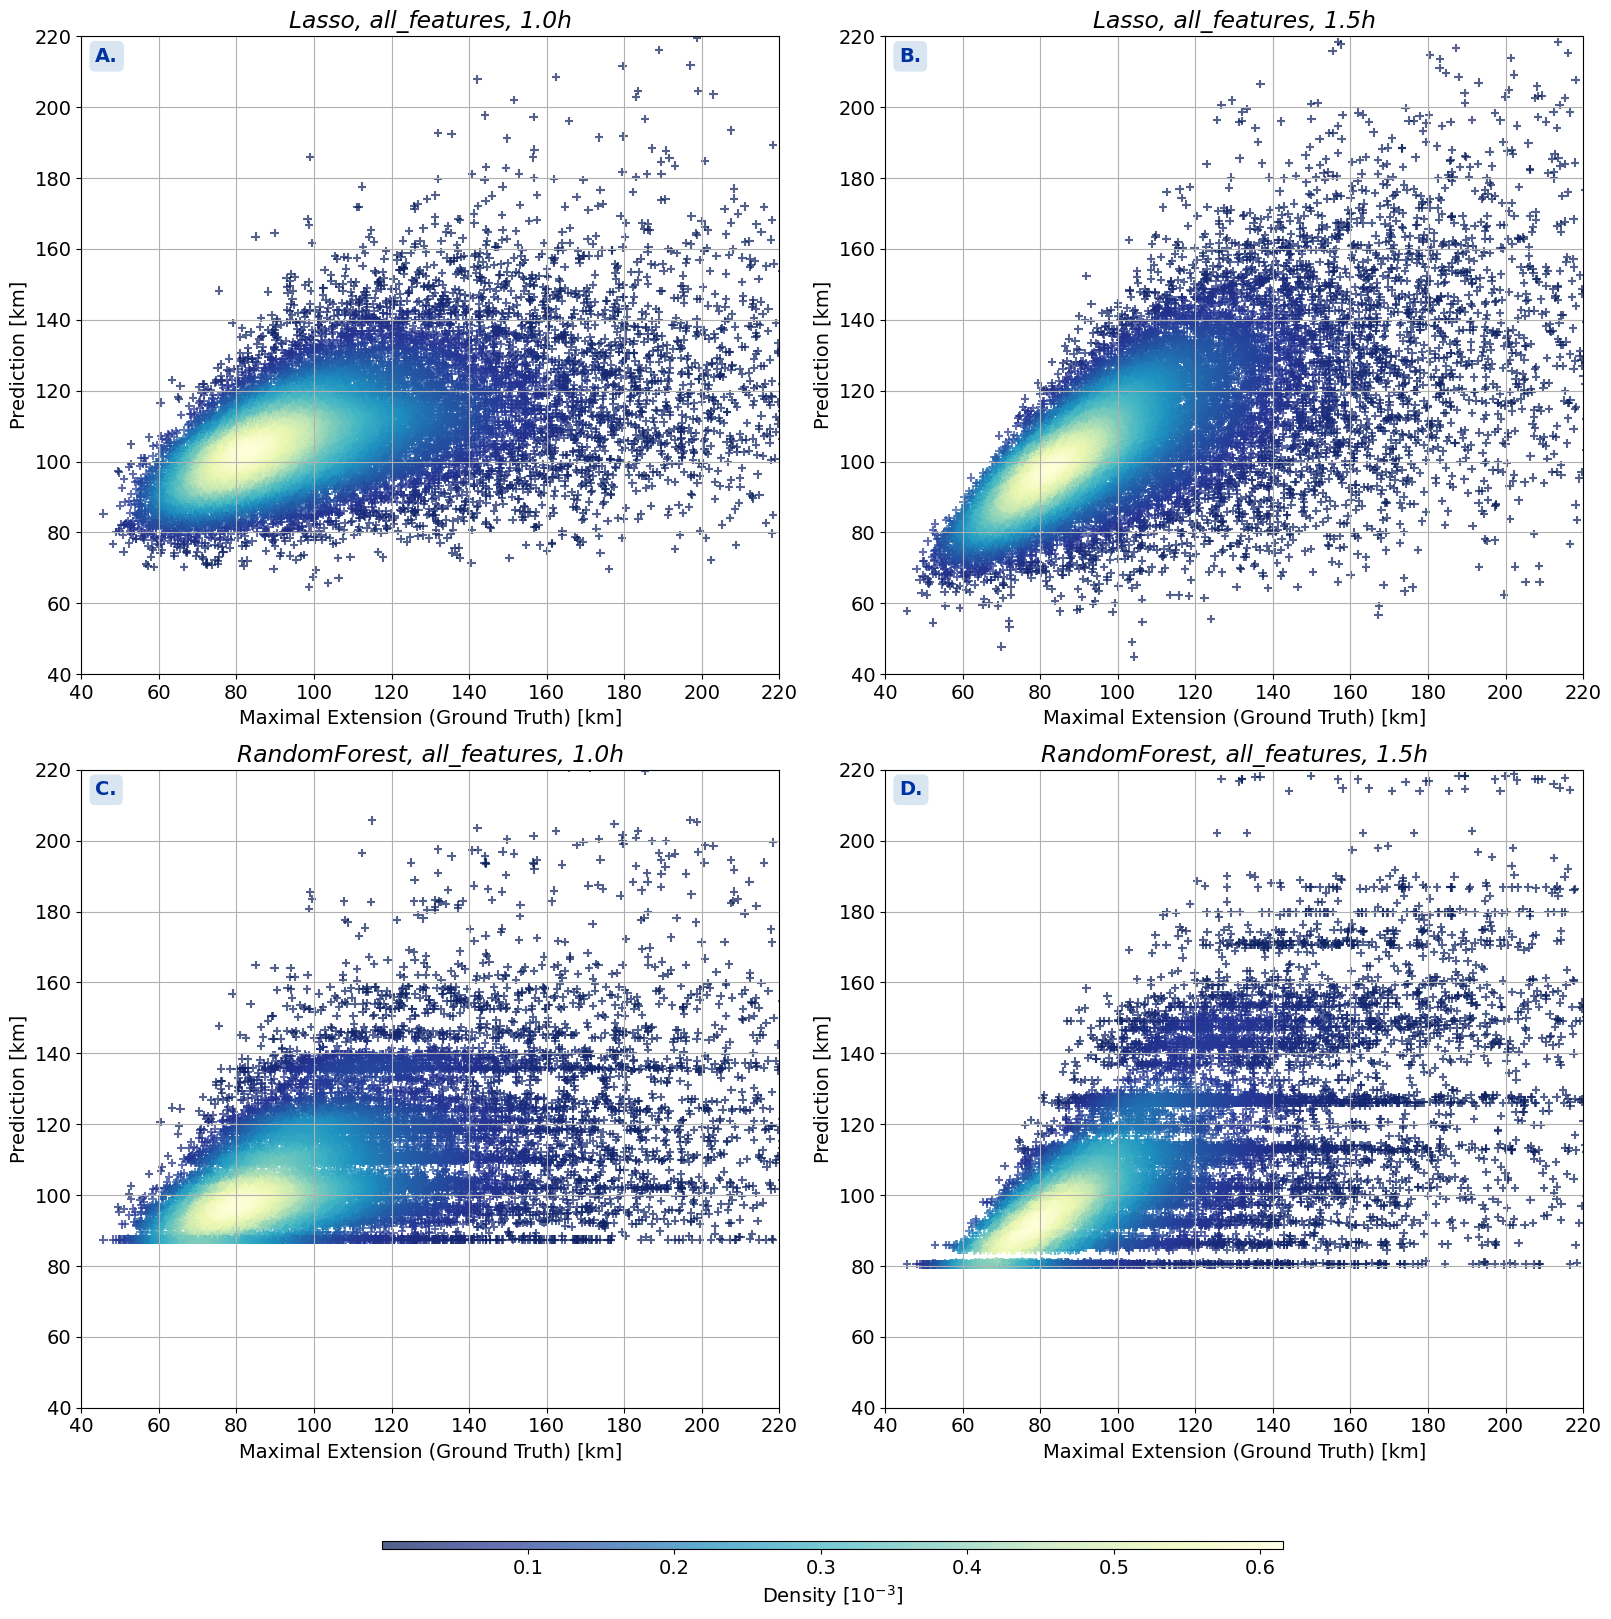

In [19]:
folder_path = '/work/bb1153/b381993/data/FINAL_VERSION_new/'
folder_path_preds = os.path.join(folder_path, 'saved_preds')

fig, ax = plt.subplots(2, 2, figsize=(16,16), constrained_layout=True)
for i_model, model_str in enumerate(['Lasso', 'RandomForest']):
    for i_mode,nb_timesteps in enumerate([2, 3]):
        mode='all_features'
        
        path_to_preds_df = os.path.join(folder_path_preds, f'preds_all_models_{mode}.parquet')
        df=pd.read_parquet(path_to_preds_df)

        str_dict = f'{model_str}_{nb_timesteps}'
    
        y_preds =df_only[df_only['model']==str_dict]['preds'].values
        y_test =df_only[df_only['model']==str_dict]['truth'].values
    
    
        x=y_preds[0]
        y = y_test[0]
    
        xy = np.vstack([x,y])
        xy=np.array(xy)
        z = gaussian_kde(xy)(xy)
    
    
        im = ax[i_model, i_mode].scatter( y_test[0],  y_preds[0], marker = '+', c =1000*z, alpha=0.7, cmap='YlGnBu_r')
    
        ax[i_model, i_mode].set_xlim(40,220)
        ax[i_model, i_mode].set_ylim(40,220)
        ax[i_model, i_mode].set_title(f'{model_str}, {mode}, {nb_timesteps/2}h', fontstyle='italic')
        ax[i_model, i_mode].set_xlabel('Maximal Extension (Ground Truth) [km]')
        ax[i_model, i_mode].set_ylabel('Prediction [km]')
        ax[i_model, i_mode].grid(True)


cb=fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.6, orientation='horizontal', aspect=110, label=r'Density [$10^{-3}$]')

# Assuming you have your axes already created as ax1, ax2, and ax3
labels = ['A.', 'B.', 'C.', 'D.']
pnas_bg_color = '#d9e6f2'  # PNAS light blue color for background
pnas_text_color = '#0033a0'  # PNAS dark blue color for text

for i, ax_subi in enumerate([ax[0,0], ax[0,1], ax[1,0], ax[1,1]]):
    ax_subi.text(
        0.02, 0.96, labels[i], 
        transform=ax_subi.transAxes, 
        weight='bold',
        color=pnas_text_color,  # Text color
        bbox=dict(facecolor=pnas_bg_color, edgecolor='none', boxstyle='round,pad=0.3')  # Background color with padding
    )



#path_to_save = os.path.join(path_figures, 'figure_S4.pdf')
#plt.savefig(path_to_save)

In [93]:
%inline matplotlib

UsageError: Line magic function `%inline` not found.


In [118]:
def get_X_cols(columns, nb_timesteps):
    output_cols_1 = []
    for col in columns:
        if any([col.endswith(f'time_{i}') for i in range(nb_timesteps)]):
            output_cols_1.append(col)
            
    
    return output_cols_1

In [119]:
def get_one_feature(df, feature_name):
    output_col = []
    for col in df.columns:
        if col.startswith(f'{feature_name}'):
            output_col.append(col)

    
    return output_col

In [120]:
def get_features_importance(path_model, model_str, df_train, nb_timesteps):
    path_file = os.path.join(path_model,f'{model_str}_ALL_FEATURES_{nb_timesteps}.joblib')
    model = get_model(model_str)
    model = joblib.load(path_file)
    
    if model_str=='Lasso':
        feature_importances = model.coef_
        feature_importances_abs = np.abs(model.coef_)
    elif model_str=='RandomForest':
        feature_importances = model.feature_importances_
        feature_importances_abs = np.abs(model.feature_importances_)
        
    index_argsort = np.argsort(feature_importances_abs)[::-1]
    values_features = feature_importances[index_argsort]
    
    columns_cut = get_X_cols(df_train.columns, nb_timesteps=nb_timesteps)
    df_train_cut = df_train[columns_cut]
    features_selected_names = df_train_cut.columns[index_argsort]
    
    return features_selected_names, values_features, index_argsort
    
    
    


In [121]:
features_selected_names_lasso, values_features_lasso, index_argsort_lasso = get_features_importance(path_model='/work/bb1153/b381993/data/FINAL_VERSION_new/saved_models/',
                        model_str='Lasso',
                        df_train=df_train,
                        nb_timesteps=nb_timesteps)
features_selected_names_lasso[:15]
nice_names_for_plot = ['growth rate*', 'std IWP*', 'equivalent diameter*', 'mean temperature of neighbors', 
                       'std IWP (total domain)', 'std LWNTA*', 'mean OM700hPa*', 'std IWP* (initial)', 
                       'eccentricity (core)', 'mean LWNTA*', "neighbor's interaction (max)",  "neighbor's interaction (mean)",
                       'migration distance', 'eccentricity (envelop)','landmask'] 

dict_for_plot = pd.DataFrame({'previous_name':features_selected_names_lasso[:15], 'new_nice_name':nice_names_for_plot})

In [122]:
dict_for_plot

,previous_name,new_nice_name
0,gradient_area_time_2,growth rate*
1,std_under_cloud_var_6_time_2,std IWP*
2,std_everywhere_var_6_time_2,equivalent diameter*
3,average_diameter_time_2,mean temperature of neighbors
4,mean_under_cloud_var_1_time_1,std IWP (total domain)
5,migration_dist_time_2,std LWNTA*
6,mean_under_all_mcs_neighbours_var_5_time_2,mean OM700hPa*
7,eccentricity_172_time_2,std IWP* (initial)
8,mean_under_cloud_var_11_time_2,eccentricity (core)
9,max_interaction_power_time_2,mean LWNTA*


In [123]:
def plot_features_importance(model_str, nb_selected, path_model, df_train, nb_timesteps, automatic_name:bool=False):
    features_selected_names, values_features, index_argsort = get_features_importance(path_model='/work/bb1153/b381993/data/FINAL_VERSION_new/saved_models/',
                        model_str=model_str,
                        df_train=df_train,
                        nb_timesteps=nb_timesteps)

    fig, ax = plt.subplots(figsize=(10,6), constrained_layout=True)

    sel_features = features_selected_names[:nb_selected][::-1]
    y_pos = np.arange(len(sel_features))

    performance = values_features[:nb_selected][::-1]

    ax.barh(y_pos, performance, align='center', color=plt.get_cmap('Spectral')(0.85))


    labels= [dict_for_plot[dict_for_plot['previous_name']==features_selected_names[:15][i]]['new_nice_name'].values[0] for i in range(15)][::-1]


    plt.yticks(y_pos, labels=labels)

    # Assuming you have your axes already created as ax1, ax2, and ax3

    pnas_bg_color = '#d9e6f2'  # PNAS light blue color for background
    pnas_text_color = '#0033a0'  # PNAS dark blue color for text
        


    #plt.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Coefficients')
    if model_str=='Lasso':
        plt.title(f'Attributed coefficients for {model_str}', fontstyle='italic')
        labels = ['A.']
    else:
        ax.set_title(f'Important features for {model_str}', fontstyle='italic')
        labels = ['B.']
    ax.grid(True)

    ax.text(
            0.02, 0.93, labels[0], 
            weight='bold',
            transform = ax.transAxes,
            color=pnas_text_color,  # Text color
            bbox=dict(facecolor=pnas_bg_color, edgecolor='none', boxstyle='round,pad=0.3')  # Background color with padding
        )


    #ax.tight_layout()
    #plt.show()

In [124]:
fig = plt.figure(figsize=(15,9), constrained_layout=True)

df_names=pd.read_csv('/home/b/b381993/DeepFate/notebooks/name_dict.csv')
model_str = 'Lasso'
nb_timesteps=3
nb_selected=15
path_model='/work/bb1153/b381993/data/FINAL_VERSION_new/saved_models/'
df_train=df_train
            
plot_features_importance(model_str, nb_selected, path_model, df_train, nb_timesteps, automatic_name=True)




path_to_save = os.path.join(path_figures, 'figure_S7A.pdf')
plt.savefig(path_to_save)

In [125]:
features_selected_names_rf, values_features_rf, index_argsort_rf = get_features_importance(path_model='/work/bb1153/b381993/data/FINAL_VERSION_new/saved_models/',
                        model_str='RandomForest',
                        df_train=df_train,
                        nb_timesteps=nb_timesteps)
features_selected_names_rf[:15]
nice_names_for_plot = ['growth rate*', 'std IWP (total domain)', 'equivalent diameter*', 'mean OM700hPa*',
                       'std IWP*','migration distance', 'mean OM700hPa*','mean IWP (total domain)',  'mean OM850hPa*',
                       'mean IWP (total except sys.)', 'mean OM850h (neighbors)', 'mean IWP (neighbors, initial)', 
                       'std U10m (total domain)',  'mean IWP (neighbors, 1h)', 'std U10m (total domain)']
                       

dict_for_plot = pd.DataFrame({'previous_name':features_selected_names_rf[:15], 'new_nice_name':nice_names_for_plot})

In [126]:
dict_for_plot

,previous_name,new_nice_name
0,gradient_area_time_2,growth rate*
1,std_everywhere_var_6_time_2,std IWP (total domain)
2,average_diameter_time_2,equivalent diameter*
3,mean_under_cloud_var_11_time_2,mean OM700hPa*
4,std_under_cloud_var_6_time_2,std IWP*
5,migration_dist_time_2,migration distance
6,mean_under_cloud_var_12_time_2,mean OM700hPa*
7,mean_everywhere_var_6_time_2,mean IWP (total domain)
8,mean_under_cloud_var_10_time_2,mean OM850hPa*
9,mean_everywhere_except_cloud_var_6_time_2,mean IWP (total except sys.)


In [127]:
fig = plt.figure(figsize=(15,9), constrained_layout=True)

df_names=pd.read_csv('/home/b/b381993/DeepFate/notebooks/name_dict.csv')
model_str = 'RandomForest'
nb_timesteps=3
nb_selected=15
path_model='/work/bb1153/b381993/data/FINAL_VERSION_new/saved_models/'
df_train=df_train

plot_features_importance(model_str, nb_selected, path_model, df_train, nb_timesteps, automatic_name=True)
path_to_save = os.path.join(path_figures, 'figure_S7B.pdf')
plt.savefig(path_to_save)

In [128]:
from DeepFate import config
config.INPUT_VARIABLES

['MCS_segmentation',
 'LWNTA.2D',
 'PW.2D',
 'RH500.2D',
 'RH700.2D',
 'T2mm.2D',
 'IWP.2D',
 'U10m.2D',
 'V10m.2D',
 'LANDMASK.2D',
 'OM500.2D',
 'OM700.2D',
 'OM850.2D']

In [129]:
features_selected_names_lasso, values_features_lasso, index_argsort_lasso = get_features_importance(path_model='/work/bb1153/b381993/data/FINAL_VERSION_new/saved_models/',
                        model_str='Lasso',
                        df_train=df_train,
                        nb_timesteps=nb_timesteps)
features_selected_names_lasso[:15]


Index(['gradient_area_time_2', 'std_under_cloud_var_6_time_2',
       'std_everywhere_var_6_time_2', 'average_diameter_time_2',
       'mean_under_cloud_var_1_time_1', 'migration_dist_time_2',
       'mean_under_all_mcs_neighbours_var_5_time_2', 'eccentricity_172_time_2',
       'mean_under_cloud_var_11_time_2', ' max_interaction_power_time_2',
       'mean_everywhere_var_9_time_1', 'mean_under_cloud_var_12_time_2',
       'std_everywhere_var_7_time_2', ' mean_interaction_power_time_0',
       'mean_under_cloud_var_5_time_0'],
      dtype='object')

In [130]:
nice_names_for_plot = ['growth rate*', 'std IWP*','std IWP (total)', 'equivalent diameter*', 'mean LWNTA*', 
                       'migration distance', 'mean surface temp. of neighbors', 'eccentricity (core)', 'mean OM700Pa*',
                       'interaction with neighbors (max)','landmask', 'mean OM850hPa*', 'std U10m', 
                       'interaction with neighbors (mean)', 'mean surface temperature*'
                      ] 

dict_for_plot = pd.DataFrame({'previous_name':features_selected_names_lasso[:15], 'new_nice_name':nice_names_for_plot})

In [131]:
#new_name_features_selected= [df_names[df_names['Old Name']==features_selected_names_lasso[:15][i]]['Name Plot'].values[0] for i in range(15)]
new_name_features_selected= [dict_for_plot[dict_for_plot['previous_name']==features_selected_names_lasso[:15][i]]['new_nice_name'].values[0] for i in range(15)]


In [132]:
df_train_cut = df_train[features_selected_names_lasso[:15]]
scaler = StandardScaler().fit(df_train_cut.values)
X_train = scaler.transform(df_train_cut.values)
y_train = df_train['y_max_extend']


In [133]:
dict_for_plot

,previous_name,new_nice_name
0,gradient_area_time_2,growth rate*
1,std_under_cloud_var_6_time_2,std IWP*
2,std_everywhere_var_6_time_2,std IWP (total)
3,average_diameter_time_2,equivalent diameter*
4,mean_under_cloud_var_1_time_1,mean LWNTA*
5,migration_dist_time_2,migration distance
6,mean_under_all_mcs_neighbours_var_5_time_2,mean surface temp. of neighbors
7,eccentricity_172_time_2,eccentricity (core)
8,mean_under_cloud_var_11_time_2,mean OM700Pa*
9,max_interaction_power_time_2,interaction with neighbors (max)


In [134]:
fig = plt.figure(figsize=(15,9), constrained_layout=True)


df = pd.DataFrame(data=X_train)
df['Amax'] = y_train
import seaborn as sns

sns.heatmap(df.corr(),annot=True, cmap='Spectral', vmin=-1, vmax=1, fmt=".1f", linewidth=.5, cbar_kws={'label': 'Correlation factor [1]'})

list_corr_name =  new_name_features_selected[:15]
list_corr_name.append(r'$\sqrt{A_{max}}$')

plt.xticks(np.linspace(0.5,15.5, 16), list_corr_name, rotation=90)
plt.yticks(np.linspace(0.5,15.5, 16), list_corr_name, rotation=0)


plt.title('Correlation between selected features', fontstyle='italic')

#path_fig = os.path.join(path_figures, 'correl_features_matrx.pdf')

#plt.savefig(path_fig)

path_to_save = os.path.join(path_figures, 'figure_S8.pdf')
plt.savefig(path_to_save)

In [135]:
df_test_cor  = pd.DataFrame({'aa' :df_train['mean_under_cloud_var_1_time_1'].values,
                'bb':df_train['mean_under_cloud_var_5_time_0'].values})
print(df_test_cor.corr())

          aa        bb
aa  1.000000  0.840515
bb  0.840515  1.000000


In [136]:
plt.scatter(df_train['mean_under_cloud_var_1_time_1'].values,
            df_train['mean_under_cloud_var_5_time_0'].values)


In [137]:
features_selected_names_lasso[:15]

Index(['gradient_area_time_2', 'std_under_cloud_var_6_time_2',
       'std_everywhere_var_6_time_2', 'average_diameter_time_2',
       'mean_under_cloud_var_1_time_1', 'migration_dist_time_2',
       'mean_under_all_mcs_neighbours_var_5_time_2', 'eccentricity_172_time_2',
       'mean_under_cloud_var_11_time_2', ' max_interaction_power_time_2',
       'mean_everywhere_var_9_time_1', 'mean_under_cloud_var_12_time_2',
       'std_everywhere_var_7_time_2', ' mean_interaction_power_time_0',
       'mean_under_cloud_var_5_time_0'],
      dtype='object')

In [92]:
from sklearn.decomposition import PCA
pca = PCA(n_components=12)
pca_fit = pca.fit_transform(X_train)

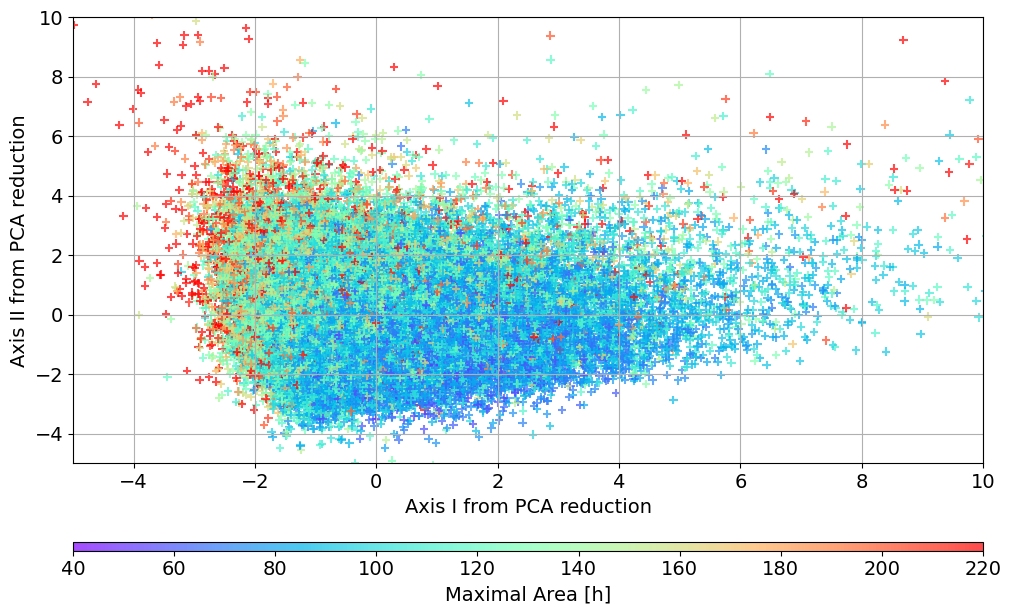

In [159]:
fig = plt.figure(figsize=(10,6), constrained_layout=True)

im = plt.scatter(pca_fit[:,0], pca_fit[:,1], c = y_train, alpha=0.7, marker = '+', cmap='rainbow')
#im = plt.scatter(x_tsne[mistake_area_index,0], x_tsne[mistake_area_index,1], marker='+', color='k')

plt.colorbar(im, orientation='horizontal', label='Maximal Area [h]', aspect=110)
plt.clim(40,220)
plt.grid(True)
plt.xlabel(r'Axis I from PCA reduction')
plt.ylabel(r'Axis II from PCA reduction')
plt.xlim(-5,10)
plt.ylim(-5,10)

#plt.title(f'Cartography of MCS', fontstyle='italic')

path_to_save = os.path.join(path_figures, 'figure_S9.pdf')
plt.savefig(path_to_save)